<a href="https://colab.research.google.com/github/BhavyaGoyal777/BackpropFromScratchWithVisualization/blob/main/BackpropPartONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data=data
    self._prev=set(_children)
    self._op=_op
    self.label=label
    self.grad=0.0
    self._backward=lambda:None


  def __repr__(self):
    return f'Value(data={self.data})'
  def __add__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out=Value(self.data+other.data,(self,other),"+")

    def _backward():
      self.grad+=1.0 * out.grad
      other.grad+=1.0 * out.grad
    out._backward=_backward

    return out
  def __neg__(self):
    return self * -1
  def __sub__(self,other):
    return self+(-other)


  def __mul__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out=Value(self.data*other.data,(self,other),"*")


    def _backward():
      self.grad+=other.data * out.grad
      other.grad+=self.data * out.grad
    out._backward=_backward
    return out


  def __pow__(self,other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out=Value(self.data**other,(self,),f'**{other}')
    def _backward():
      self.grad+=other * (self.data**(other-1)) * out.grad
    out._backward=_backward
    return out


  def __rmul__(self,other):
    return self * other      #to handle the reverse case of 2 * Value(data)\


  def __truediv__(self,other):
    return self* (other**-1)


  def tanh(self):
    x=self.data
    ans=(math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out=Value(ans,(self, ),'tanh')

    def _backward():
      self.grad+=(1-ans**2)*out.grad
    out._backward=_backward
    return out

  def exp(self):
    x=self.data
    out=Value(np.exp(x),(self,),'exp')
    def _backward():
      self.grad=out.data * out.grad
    out._backward=_backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad=1.0
    for node in reversed(topo):
      node._backward()


In [3]:
a=Value(8)
b=Value(4)
a-b

Value(data=4)

In [4]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | %.4f }" % (n.label,n.data,n.grad), shape='record')

        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [5]:
# a=Value(2,label="a")
# b=Value(-3,label='b')
# c=Value(10,label='c')
# e=a*b
# d=e+c
# d.label="d"
# e.label='e'
# f=Value(-2.0,label='f')
# L=d*f
# L.label="L"

In [6]:
# draw_dot(L)


In [7]:
# L.grad=1.0
# d.grad=f.data
# f.grad=d.data
# c.grad=f.data
# e.grad=f.data
# a.grad=b.data * f.data
# b.grad=a.data * f.data
# a.data

In [8]:
#using a single perceptron and run backprop on it
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#-----------------------
# L=n.tanh()

e=(2*n).exp()
L=(e-1)/(e+1)

L.label='L'
L.backward()


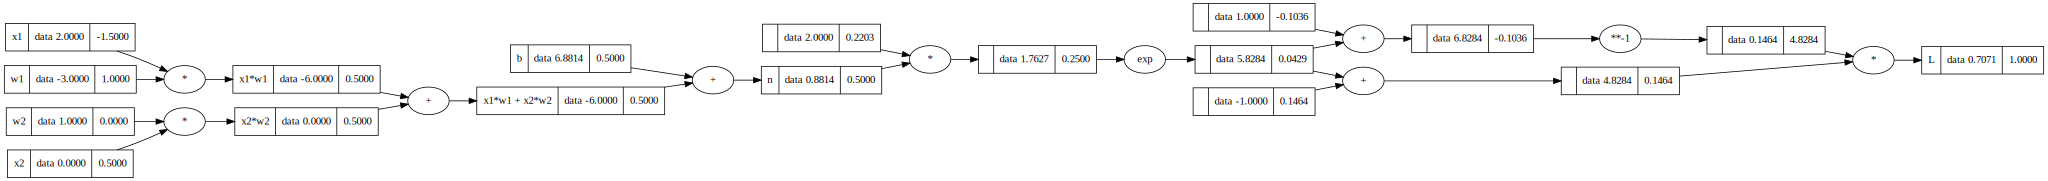

In [9]:
draw_dot(L)

In [10]:
# L.grad=1.0
# n.grad=1-L.data**2
# b.grad=n.grad
# x1w1x2w2.grad=n.grad
# x1w1.grad=x1w1x2w2.grad
# x2w2.grad=x1w1x2w2.grad
# x1.grad=w1.data*x1w1.grad
# w1.grad=x1.data*x1w1.grad
# x2.grad=w2.data*x2w2.grad
# w2.grad=x2.data*x2w2.grad






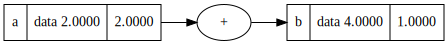

In [11]:
a=Value(2.0,label='a')
b=a+a
b.label="b"
b.backward()
draw_dot(b)

In [12]:
import torch
import random

In [13]:
x1 = torch.Tensor([2.0]).double()                           ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                           ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                          ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                           ;w2.requires_grad=True
b=torch.Tensor([6.8813735870195432])                        ;b.requires_grad=True
n=x1*w1 + x2*w2 + b
o=torch.tanh(n)
print(o.data.item())
o.backward()
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())
print('b',b.grad.item())



0.7071066904050358
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0
b 0.5000001192092896


In [14]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print(n)

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
tensor([0.8814], dtype=torch.float64, grad_fn=<AddBackward0>)


In [15]:
#nin=no of inputs

class Neuron:
  def __init__(self,nin):
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(random.uniform(-1,1))


  def __call__(self,x):
   o=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
   t=o.tanh()
   return t
class Layer:
  def __init__(self,nin,non):
    self.neurons=[Neuron(nin) for _ in range(non)]
  def __call__(self,x):
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs
#nouts=list of no of neurons in echa layer ex[3,2,3] layer 1 has 3 neurons then layer 2 has 2 neurons and layer 3 has 3 neurons
class MLP:
  def __init__(self,nin,nouts):
    sz=[nin]+nouts
    # print(sz)
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
      # print(x)
    return x





In [18]:
x=[3.0,2.3,1]
m=MLP(3,[4,4,1])
m(x).backward()

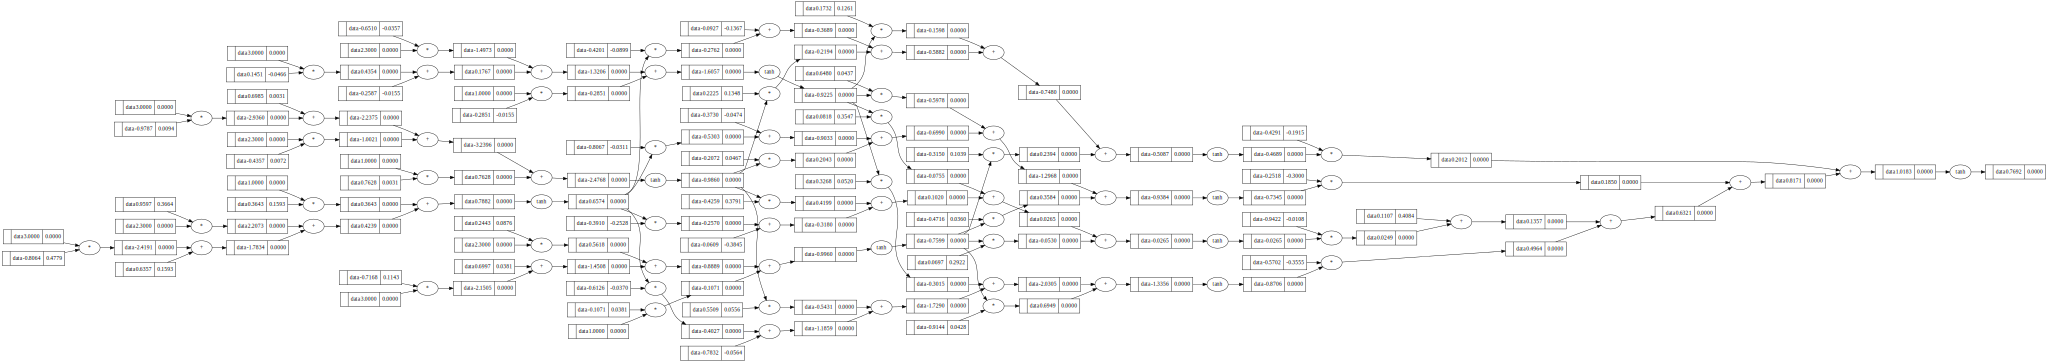

In [19]:
draw_dot(m(x))